In [39]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings('ignore', message="The sklearn.metrics.classification module", category=FutureWarning)
warnings.filterwarnings('ignore', message=".*title_format is deprecated. Please use title instead.*")
warnings.filterwarnings('ignore', message="optional dependency `torch` is not available. - skipping import of NN models.")
warnings.filterwarnings('ignore', message="The default value of regex will change from True to False in a future version.",
                        category=FutureWarning)

import os
import os.path as op
import shutil
import bokeh

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime

from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
import seaborn as sns


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
import sys
import panel as pn
pn.extension('bokeh')
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

bokeh extension not recognized and will be skipped.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
#standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning, initialize_environment,
    get_package_path, display_as_tabs, save_data, save_pipeline, load_dataframe, load_pipeline, load_dataset, DEFAULT_ARTIFACTS_PATH
)
import ta_lib.core.api as dataset
import ta_lib.eda.api as ta_analysis
from ta_lib.reports.api import create_report
import ta_lib.reports.api as health
from sklearn.ensemble import RandomForestClassifier
from ta_lib.classification.api import ClassificationComparison, ClassificationReport, confusion_matrix_by_feature, SKLStatsmodelLogit
from ta_lib.data_processing.api import Outlier, WoeBinningTransformer

#from scripts import *

os.environ['TA_DEBUG'] = "False"
os.environ['TA_ALLOW_EXCEPTIONS'] = "True"

# Initialization
initialize_environment(debug=False, hide_warnings=True)

ModuleNotFoundError: No module named 'numpy._typing'

In [41]:
%matplotlib inline

In [42]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)
print(dataset.list_datasets(context))

['/raw/sod', '/raw/spd', '/cleaned/opt_data', '/cleaned/prd_data', '/processed/merged_df', '/processed/premodel']


In [43]:
#loading dataset
data = dataset.load_dataset(context,'/processed/merged_df')

In [8]:
data.drop(columns=['Unnamed: 0'],axis=1,inplace= True)
data.head()

,opportunity id,transition to stage,transition to timestamp,transition from stage name,transition from timestamp,customer name,risk status,creation date,decision date,win,...,product id,product status,product $,product quantity,snapshot time,opportunity average price,opportunity total quantity,no of products,no of products lost,no of products won
0,5,3,2015-02-11 13:00:01,0,NaN,83,0,2015-02-11,2015-03-12,1,...,404,0,230400,1200,2015-02-11 21:00:01,230400.0,1200,1,1,0
1,5,3,2015-02-13 05:00:02,3,2015-02-11 13:00:01,83,0,2015-02-11,2015-03-12,1,...,404,0,230400,1200,2015-02-11 21:00:01,230400.0,1200,1,1,0
2,5,3,2015-02-18 21:00:07,3,2015-02-13 05:00:02,83,0,2015-02-11,2015-03-12,1,...,404,0,230400,1200,2015-02-11 21:00:01,230400.0,1200,1,1,0
3,5,3,2015-03-04 21:00:02,3,2015-02-18 21:00:07,83,0,2015-02-11,2015-03-12,1,...,404,0,230400,1200,2015-02-11 21:00:01,230400.0,1200,1,1,0
4,5,3,2015-03-04 21:00:02,3,2015-03-04 21:00:02,83,0,2015-02-11,2015-03-12,1,...,404,0,230400,1200,2015-02-11 21:00:01,230400.0,1200,1,1,0


In [44]:
import ta_lib.eda.api as eda
sum1 = eda.get_outliers(data)
display_as_tabs([("merged_data", sum1)])

Tabs
    [0] DataFrame(height=300, name='merged_data', sizing_mode='fixed', value=              ..., width=800)

In [46]:
merged_data=data.copy()
merged_data.drop(columns=['transition from timestamp','customer name','snapshot time',],inplace=True)

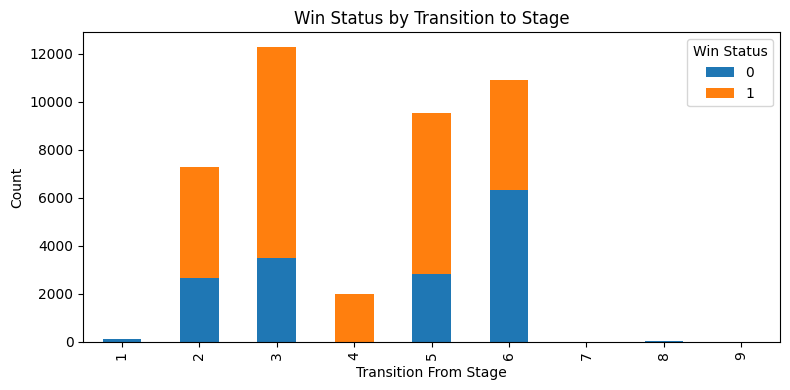

In [47]:
# Win ratio after each "to stage transition"
stage_win_counts = merged_data.groupby(['transition to stage', 'win']).size().unstack()
stage_win_counts.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Win Status by Transition to Stage')
plt.xlabel('Transition From Stage')
plt.ylabel('Count')
plt.legend(title='Win Status', loc='upper right')
plt.show()
# INFERENCE : winning opportunity is likely to exsist in stage 4

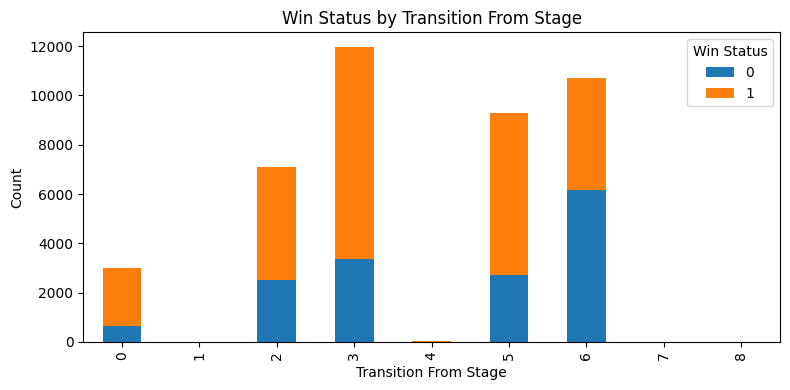

In [48]:
# Win ratio after each "from stage transition"
stage_win_counts = merged_data.groupby(['transition from stage name', 'win']).size().unstack()
stage_win_counts.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Win Status by Transition From Stage')
plt.xlabel('Transition From Stage')
plt.ylabel('Count')
plt.legend(title='Win Status', loc='upper right')
plt.show()
# INFERENCE: the loss of oppotunity is slighlty more observed in stages 0,2,3

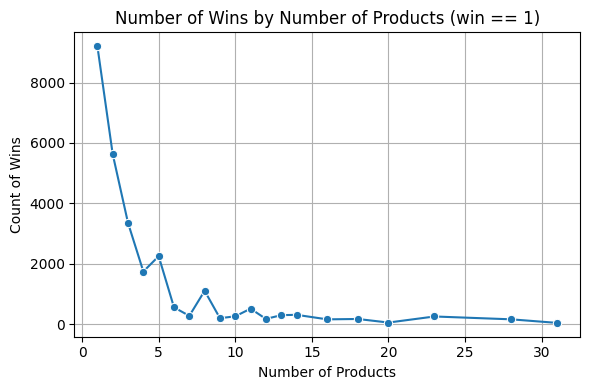

In [49]:
# Out of each bin of number of products winning ratio for each bin
win_df = merged_data[merged_data['win'] == 1]
products_win_count = win_df.groupby('no of products').size().reset_index(name='count')
plt.figure(figsize=(6, 4))
sns.lineplot(x='no of products', y='count', data=products_win_count, marker='o')
plt.title('Number of Wins by Number of Products (win == 1)')
plt.xlabel('Number of Products')
plt.ylabel('Count of Wins')
plt.grid(True)
plt.show()

# INFERENCE: that number of customers with less total products are more likely toh be won oppotunity
# INFERENCE: as the distribution of the "num of product" category is right skewed the winning rate/ number of opportunity is also right skewed.

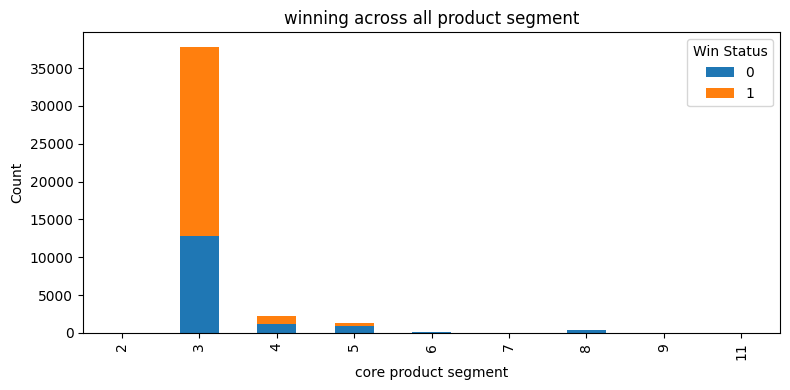

In [50]:
#Plotting winning ratio for each product segement
stage_win_counts = merged_data.groupby(['core product segment', 'win']).size().unstack()
stage_win_counts.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('winning across all product segment')
plt.xlabel('core product segment')
plt.ylabel('Count')
plt.legend(title='Win Status', loc='upper right')
plt.show()

#INFERENCE : Each product category is equally likely to be won

In [51]:
merged_data_copy=merged_data.copy()
print(merged_data['core consumption market'].value_counts())
mapping = {4: 0, 16: 0, 7: 0, 11: 0,9:1,8:1,10:1,19:1,6:2,14:2,18:2,12:2,13:3,17:3,5:3,3:3,15:3,2:3}
merged_data_copy['core consumption market'].replace(mapping, inplace=True)
merged_data_copy['core consumption market'] = merged_data_copy['core consumption market'].apply(lambda x: -1 if x not in mapping.values() else x)

print(merged_data_copy['core consumption market'].value_counts())
print(merged_data_copy['core consumption market'].describe())
merged_data['core consumption market']=merged_data_copy['core consumption market']

4     10605
16     4980
7      4007
11     3521
9      3315
8      3272
10     2537
6      2109
19     1791
14     1293
12     1143
18     1037
17      764
13      714
5       509
3       283
15      245
2        12
Name: core consumption market, dtype: int64
0    23113
1    10915
2     5582
3     2527
Name: core consumption market, dtype: int64
count    42137.000000
mean         0.703894
std          0.912808
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: core consumption market, dtype: float64


In [52]:
merged_data_copy=merged_data.copy()
print(merged_data['core product segment'].value_counts())
merged_data_copy['core product segment'] = merged_data_copy['core product segment'].apply(lambda x: 0 if x == 3 else 1)
print(merged_data_copy['core product segment'].describe())
merged_data['core product segment']=merged_data_copy['core product segment']

3     37832
4      2279
5      1334
8       440
6       153
7        40
9        38
2        18
11        3
Name: core product segment, dtype: int64
count    42137.000000
mean         0.102167
std          0.302871
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: core product segment, dtype: float64


In [53]:
print(merged_data['core sales segment'].describe())
merged_data['core sales segment'] = merged_data['core sales segment'].apply(lambda x: 0 if x == 8 else 1)
print(merged_data['core sales segment'].describe())

count    42137.000000
mean         6.723070
std          2.742897
min          1.000000
25%          8.000000
50%          8.000000
75%          8.000000
max         18.000000
Name: core sales segment, dtype: float64
count    42137.000000
mean         0.281226
std          0.449603
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: core sales segment, dtype: float64


In [54]:
print(merged_data['geography'].value_counts())
mapping = {2:0,3:1,4:2,5:3}
merged_data['geography'].replace(mapping, inplace=True)
merged_data = merged_data[merged_data['geography'] != -1]
print(merged_data['geography'].value_counts())

 3    16704
 4    10562
 2     7868
 5     4902
-1     2101
Name: geography, dtype: int64
1    16704
2    10562
0     7868
3     4902
Name: geography, dtype: int64


In [55]:
print(merged_data['core product application'].value_counts())
mapping = {13:0,4:1}
merged_data['core product application'].replace(mapping, inplace=True)
merged_data['core product application'] = merged_data['core product application'].apply(lambda x: 2 if x not in mapping.values() else x)
print(merged_data['core product application'].describe())

13    15705
4     13107
22     4736
14     1840
8      1005
5       933
15      768
38      423
21      333
11      298
17      138
9       102
19       87
16       66
10       57
18       51
40       45
35       42
34       38
23       33
7        31
28       29
25       23
47       22
2        19
42       18
46       16
33       15
1        14
12       11
29        6
3         6
37        4
20        4
49        3
27        3
45        2
43        2
36        1
Name: core product application, dtype: int64
count    40036.000000
mean         0.887726
std          0.812207
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: core product application, dtype: float64


In [56]:
# Encoding " transtion from stage name "
merged_data['transition from stage name'].replace([0,6,5],0,inplace=True) # early stages
merged_data['transition from stage name'].replace([3,2],1,inplace=True) # next stages
merged_data['transition from stage name'].replace([4,9],2,inplace=True) # win stages
merged_data['transition from stage name'].replace([1,7,8],3,inplace=True) # loss and ignore stages
merged_data['transition from stage name'].value_counts()

0    21797
3    18239
Name: transition from stage name, dtype: int64

divide by zero encountered in log


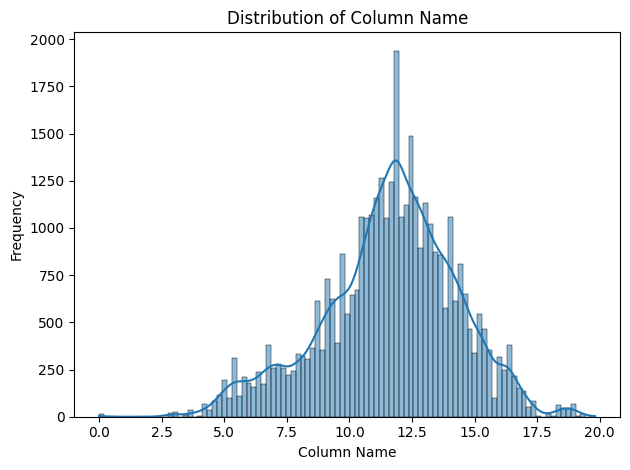

In [57]:
# Plotting distribution curve for " product $ "
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(np.log(merged_data['product $'].dropna()), kde=True)
plt.xlabel('Column Name')
plt.ylabel('Frequency')
plt.title('Distribution of Column Name')
plt.show()

# Inference the graph is left skewed and values lie in range of (0,2000), hence we apply logarithmic transformation

count    4.003600e+04
mean     2.018178e+06
std      1.248710e+07
min      0.000000e+00
25%      1.429500e+04
50%      1.153920e+05
75%      5.620000e+05
max      4.040000e+08
Name: product $, dtype: float64
count    37720.000000
mean        11.602607
std          2.703410
min          0.000000
25%         10.077441
50%         11.852251
75%         13.391978
max         19.816925
Name: product $, dtype: float64


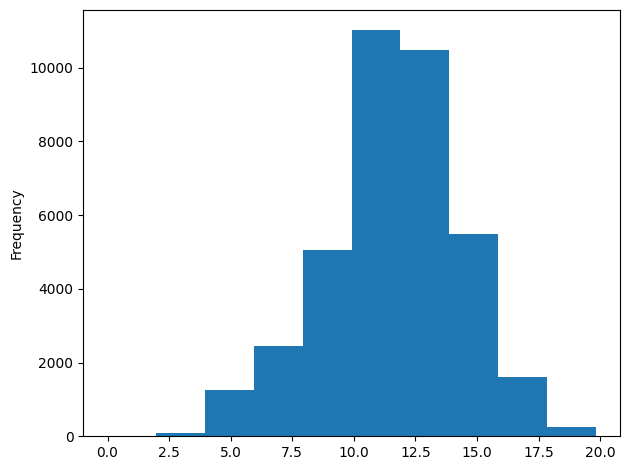

In [58]:
# Applying log transform for "product $"
merged_data_copy=merged_data.copy()
print(merged_data_copy['product $'].describe())
merged_data_copy = merged_data_copy[merged_data_copy['product $'] != 0]
(merged_data_copy['product $'])=np.log(merged_data_copy['product $'])
(merged_data_copy['product $']).plot.hist(bins = 10)
print(merged_data_copy['product $'].describe())
merged_data['product $']=merged_data_copy['product $']
# INFERENCE : now we can observe that the graph is more normalised

count    4.003600e+04
mean     6.844643e+04
std      5.330133e+05
min      0.000000e+00
25%      2.000000e+02
50%      1.001000e+03
75%      7.000000e+03
max      8.000000e+06
Name: product quantity, dtype: float64
count    39821.000000
mean         7.060394
std          3.033727
min          0.000000
25%          5.389072
50%          6.952729
75%          8.853665
max         15.894952
Name: product quantity, dtype: float64


<AxesSubplot:ylabel='Frequency'>

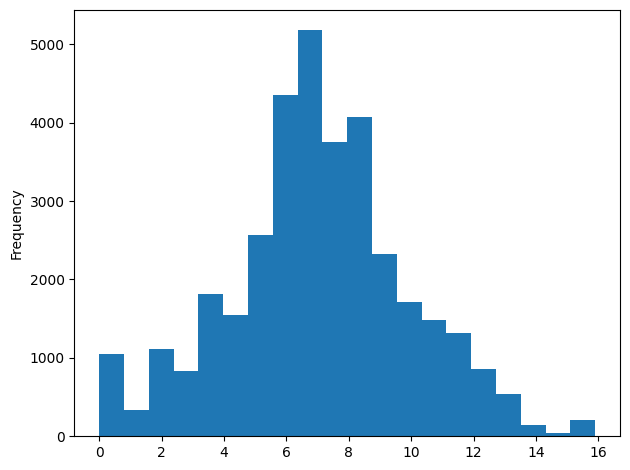

In [59]:
# Applying log transformation for "prouct quantity"
print(merged_data['product quantity'].describe())
merged_data=merged_data[merged_data['product quantity']>0]
merged_data['product quantity']=np.log(merged_data['product quantity'])
print(merged_data['product quantity'].describe())
merged_data.replace(-np.inf, np.nan, inplace=True)
merged_data.dropna(inplace=True)
merged_data['product quantity'].describe()
(merged_data['product quantity'][merged_data['product quantity']>=0]).plot.hist(bins=20)

count    34330.000000
mean       185.602272
std        202.339923
min          0.000000
25%         59.000000
50%        119.000000
75%        273.000000
max       1577.000000
Name: no of days to decision, dtype: float64
count    34330.000000
mean        12.078473
std          6.301898
min          0.000000
25%          7.681146
50%         10.908712
75%         16.522712
max         39.711459
Name: no of days to decision, dtype: float64


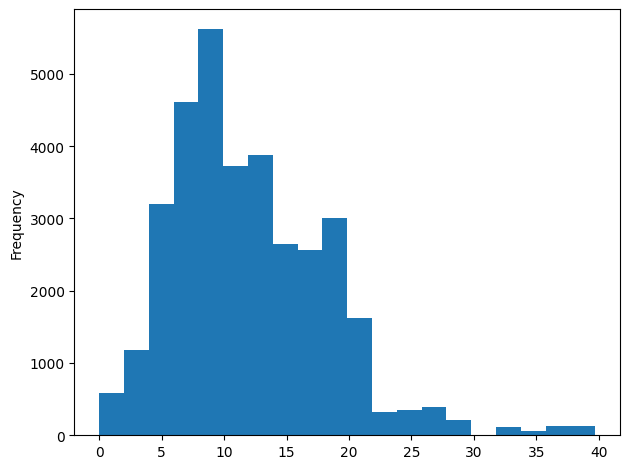

In [60]:
# Square root transform for "no of decision days"
merged_data_copy=merged_data.copy()
merged_data_copy = merged_data_copy[merged_data_copy['no of days to decision'] >= 0]
print(merged_data_copy['no of days to decision'].describe())
merged_data_copy['no of days to decision']=np.sqrt(merged_data_copy['no of days to decision'])
(merged_data_copy['no of days to decision'][merged_data_copy['no of days to decision'] >= 0]).plot.hist(bins=20)
print(merged_data_copy['no of days to decision'].describe())
merged_data['no of days to decision']=merged_data_copy['no of days to decision']

count    35251.000000
mean       196.345834
std        135.026963
min          0.000000
25%         73.000000
50%        169.000000
75%        307.000000
max        588.000000
Name: total transition days, dtype: float64
count    35251.000000
mean        13.043211
std          5.120667
min          0.000000
25%          8.544004
50%         13.000000
75%         17.521415
max         24.248711
Name: total transition days, dtype: float64


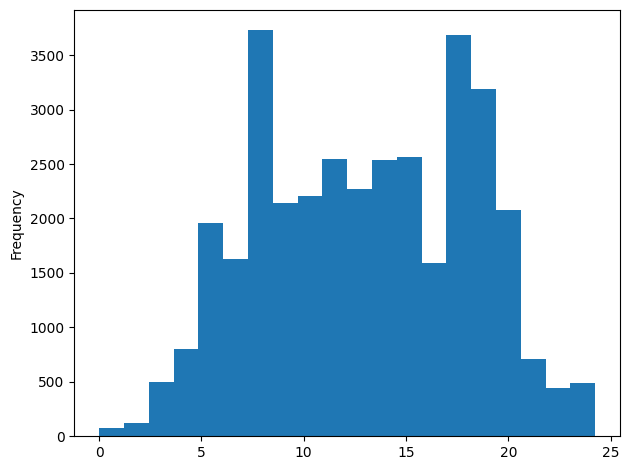

In [61]:
merged_data_copy=merged_data.copy()
print(merged_data['total transition days'].describe())
merged_data_copy = merged_data_copy[merged_data_copy['total transition days'] >= 0]
merged_data_copy['total transition days']=np.sqrt(merged_data_copy['total transition days'])
(merged_data_copy['total transition days'][merged_data_copy['total transition days'] >= 0]).plot.hist(bins=20)
print(merged_data_copy['total transition days'].describe())
merged_data['total transition days']=merged_data_copy['total transition days']

In [62]:
# saving the processed data
dataset.save_dataset(context,merged_data , '/processed/premodel')